In [ ]:
import torch
from model import DiscGraderResNet, DiscUNet
import pandas as pd
import os

In [ ]:
file_name = "179_t2"

In [ ]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

seg_model = DiscUNet(n_classes=2).to(device)
seg_model.load_state_dict(torch.load("disc_localization_unet.pth", map_location=device))
seg_model.eval()

grade_model = DiscGraderResNet(n_classes=5).to(device)
grade_model.load_state_dict(torch.load("disc_grader_resnet18.pth", map_location=device))
grade_model.eval()

In [4]:
from report_generation import (
    load_sagittal_slice,
    segment_discs,
    get_candidates_from_mask,
    select_discs_by_position,
    grade_rois,
    visualize_full_pipeline,
    compute_disc_metrics,
    save_overlay_image,
    generate_case_pdf,
)

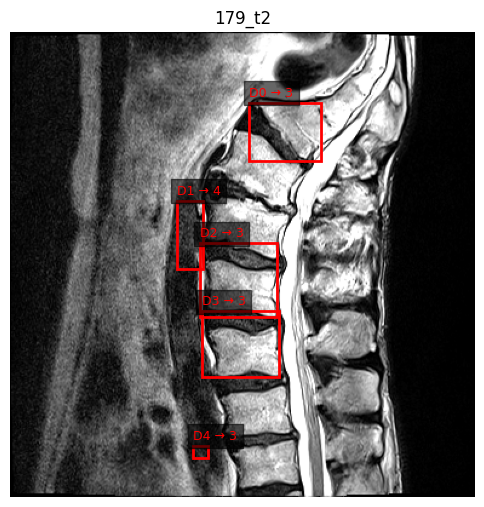

In [ ]:
root = "spider"
img = load_sagittal_slice(root, file_name)

pred_384, sy, sx = segment_discs(img, seg_model, device)

candidates = get_candidates_from_mask(pred_384)
selected = select_discs_by_position(candidates, n_discs=5)

boxes = []
for c in selected:
    slc = c["slice"]

    y0 = int(slc[0].start * sy)
    y1 = int(slc[0].stop * sy)
    x0 = int(slc[1].start * sx)
    x1 = int(slc[1].stop * sx)

    boxes.append((y0, y1, x0, x1))
preds = grade_rois(img, boxes, device, grade_model)

visualize_full_pipeline(img, boxes, preds, title=file_name)

In [8]:
metrics = compute_disc_metrics(boxes)

In [9]:
final_results = []

for d in range(len(boxes)):
    final_results.append({"disc": d, "predicted_pfirrmann": preds[d] + 1, **metrics[d]})

In [10]:
pd.DataFrame.from_dict(final_results)

,disc,predicted_pfirrmann,height_px,depth_px,hd_ratio,height_index
0,0,3,48,59,0.813559,1.048035
1,1,4,56,22,2.545454,1.222707
2,2,3,61,64,0.953125,1.331878
3,3,3,54,64,0.843750,1.179039
4,4,3,10,12,0.833333,0.218341


In [ ]:
out_root = "results"
report_dir = os.path.join(out_root, "pdf_reports")
overlay_dir = os.path.join(out_root, "overlay_imgs")
os.makedirs(report_dir, exist_ok=True)
os.makedirs(overlay_dir, exist_ok=True)
case_name = file_name.replace(".mha", "")
overlay_path = os.path.join(overlay_dir, f"{case_name}_overlay.png")

save_overlay_image(img, boxes, preds, overlay_path, title=case_name)

metrics = compute_disc_metrics(boxes)

pdf_path = os.path.join(report_dir, f"{case_name}_report.pdf")

generate_case_pdf(
    case_id=case_name,
    overlay_img_path=overlay_path,
    metrics=metrics,
    out_pdf_path=pdf_path,
)